In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


{}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d marcozuppelli/stegoimagesdataset


Dataset URL: https://www.kaggle.com/datasets/marcozuppelli/stegoimagesdataset
License(s): DbCL-1.0


In [4]:
!unzip stegoimagesdataset.zip -d stegoimagesdataset


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: stegoimagesdataset/val/val/stego/image_06334_ps_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06334_ps_1.png  
  inflating: stegoimagesdataset/val/val/stego/image_06335_eth_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06335_html_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06335_url_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06336_html_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06336_html_1.png  
  inflating: stegoimagesdataset/val/val/stego/image_06336_url_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06337_html_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06337_js_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06337_url_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06338_eth_0.png  
  inflating: stegoimagesdataset/val/val/stego/image_06338_js_0.png  
  inflating:

In [5]:
import shutil
import os

# Chemin de base
base_path = 'stegoimagesdataset/test/test/'

# Dossiers à supprimer
folders_to_delete = ['stego_b64', 'stego_zip']

# Suppression des dossiers
for folder in folders_to_delete:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Dossier supprimé : {folder_path}")
    else:
        print(f"Dossier non trouvé : {folder_path}")

Dossier supprimé : stegoimagesdataset/test/test/stego_b64
Dossier supprimé : stegoimagesdataset/test/test/stego_zip


In [6]:
import os
from PIL import Image

def convert_clean_rgba_to_rgb(root_dirs):
    """
    Parcourt uniquement les sous-dossiers 'clean' de chacun des répertoires racines
    et convertit les images PNG RGBA en RGB.
    """
    for root in root_dirs:
        clean_dir = os.path.join(root, 'clean')
        if not os.path.isdir(clean_dir):
            continue

        for fname in os.listdir(clean_dir):
            if not fname.lower().endswith('.png'):
                continue

            path = os.path.join(clean_dir, fname)
            try:
                with Image.open(path) as img:
                    if img.mode == 'RGBA':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(path)
                        print(f"Converted RGBA → RGB: {path}")
            except Exception as e:
                print(f"Error processing {path}: {e}")

# Exemple d'utilisation :
train_dir = 'stegoimagesdataset/train/train'
val_dir   = 'stegoimagesdataset/val/val'
test_dir  = 'stegoimagesdataset/test/test'

convert_clean_rgba_to_rgb([train_dir, val_dir, test_dir])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00345.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01239.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01364.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03310.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00358.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01329.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/01610.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03138.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02468.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03176.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/00183.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/03999.png
Converted RGBA → RGB: stegoimagesdataset/train/train/clean/02955.png
Converted RGBA → RGB: ste

In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import random
import re
import cv2
import numpy as np

class BalancedStegoDatasetGPU(Dataset):
    def __init__(self, clean_dir, stego_dir, transform=None, device='cuda', apply_laplacian=False):
        self.device = device
        self.transform = transform
        self.apply_laplacian = apply_laplacian

        self.images = []
        self.labels = []

        clean_imgs = sorted([f for f in os.listdir(clean_dir) if f.endswith('.png')])

        for clean_img in clean_imgs:
            clean_path = os.path.join(clean_dir, clean_img)
            base_id = os.path.splitext(clean_img)[0]

            # === Image clean ===
            img_clean = Image.open(clean_path).convert("RGB")
            img_clean = self.preprocess(img_clean)
            self.images.append(img_clean.to(self.device))
            self.labels.append(torch.tensor(0, dtype=torch.long, device=self.device))

            # === Une stégo associée (parmi les 3 possibles) ===
            pattern = f"image_{base_id}_.+\\.png"
            stego_matches = [f for f in os.listdir(stego_dir) if re.match(pattern, f)]

            if stego_matches:
                stego_img = random.choice(stego_matches)
                stego_path = os.path.join(stego_dir, stego_img)
                img_stego = Image.open(stego_path).convert("RGB")
                img_stego = self.preprocess(img_stego)
                self.images.append(img_stego.to(self.device))
                self.labels.append(torch.tensor(1, dtype=torch.long, device=self.device))

        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def preprocess(self, img_pil):

        img_np = np.array(img_pil)

        if self.apply_laplacian:
            laplacian_channels = []
            for c in range(3):  # R, G, B
                channel = img_np[:, :, c]
                laplacian = cv2.Laplacian(channel, cv2.CV_32F)
                laplacian = cv2.convertScaleAbs(laplacian)
                laplacian_channels.append(laplacian)

            img_np = np.stack(laplacian_channels, axis=-1)

        img_pil = Image.fromarray(img_np)

        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)

        return img_tensor

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)



- RandomAffine	Simule de petites translations ➔ le modèle doit apprendre des patterns locaux, pas des positions
- ColorJitter	Simule des changements de conditions lumineuses ➔ force le modèle à se concentrer sur structure et non couleur
- GaussianBlur	Ajoute du micro bruit pour forcer le modèle à être plus sensible aux détails "fins"

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=2),  # réduit de 5° à 2°
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # centre les valeurs around 0
])

train_dir = 'stegoimagesdataset/train/train/'
val_dir = 'stegoimagesdataset/val/val/'
test_dir = 'stegoimagesdataset/test/test/'

train_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/train/train/clean',
    stego_dir='stegoimagesdataset/train/train/stego',
    transform=train_transform,
    device='cuda',
    apply_laplacian=True
)

val_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/val/val/clean',
    stego_dir='stegoimagesdataset/val/val/stego',
    transform=transform,
    device='cuda',
    apply_laplacian=True
)

test_dataset = BalancedStegoDatasetGPU(
    clean_dir='stegoimagesdataset/test/test/clean',
    stego_dir='stegoimagesdataset/test/test/stego',
    transform=transform,
    device='cuda',
    apply_laplacian=True
)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
from collections import Counter

labels_train = [int(label) for _, label in train_dataset]
labels_val = [int(label) for _, label in val_dataset]
labels_test = [int(label) for _, label in test_dataset]
print(Counter(labels_train))
print(Counter(labels_val))
print(Counter(labels_test))

for input, labels in train_loader:
  print(input.size())
  print(labels.size())
  break

Counter({0: 4000, 1: 4000})
Counter({0: 2000, 1: 2000})
Counter({0: 2000, 1: 2000})
torch.Size([32, 3, 256, 256])
torch.Size([32])


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# Use the new weights parameter instead of pretrained
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


# Replace the last layer to match the number of classes in the dataset
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes : clean and stego

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

#print(model)

Using device: cuda


In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import time

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    best_val_acc = 0.0
    epochs_without_improvement = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)


    print(f"Starting training for model: {model.__class__.__name__} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())} for {num_epochs} epochs")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        train_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")

        # --- Validation phase ---
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
        scheduler.step(val_accuracy)

        # --- Early Stopping check ---
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("New best model found!")
        else:
            epochs_without_improvement += 1
            print(f"No improvement. ({epochs_without_improvement}/{patience})")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print(f"Training complete. Best Validation Accuracy: {best_val_acc:.2f}%")
    return model


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer

trained_model = train(model, train_loader, val_loader, criterion, optimizer, 100, 25)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training for model: ResNet at 2025-04-26 10:51:10 for 100 epochs
Epoch [1/100] | Loss: 0.4795 | Train Accuracy: 75.71%
Validation Accuracy: 80.72%
New best model found!
Epoch [2/100] | Loss: 0.2941 | Train Accuracy: 89.28%
Validation Accuracy: 96.90%
New best model found!
Epoch [3/100] | Loss: 0.2960 | Train Accuracy: 88.62%
Validation Accuracy: 50.00%
No improvement. (1/25)
Epoch [4/100] | Loss: 0.2621 | Train Accuracy: 90.36%
Validation Accuracy: 99.97%
New best model found!
Epoch [5/100] | Loss: 0.2566 | Train Accuracy: 89.76%
Validation Accuracy: 50.00%
No improvement. (1/25)
Epoch [6/100] | Loss: 0.2451 | Train Accuracy: 90.15%
Validation Accuracy: 99.97%
No improvement. (2/25)
Epoch [7/100] | Loss: 0.2241 | Train Accuracy: 90.62%
Validation Accuracy: 84.92%
No improvement. (3/25)
Epoch [8/100] | Loss: 0.1977 | Train Accuracy: 90.96%
Validation Accuracy: 98.22%
No improvement. (4/25)
Epoch [9/100] | Loss: 0.1762 | Train Accuracy: 91.85%
Validation Accuracy: 99.85%
No impr

In [12]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from sklearn.metrics import classification_report

def test_model(model, loader, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_images.append(images.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_images = torch.cat(all_images)

    return all_images, all_preds, all_labels

def show_misclassified_images(images, preds, labels, classes, max_images=10):
    incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]
    print(f"Nombre d'erreurs : {len(incorrect_indices)}")

    if len(incorrect_indices) == 0:
        print("Aucun échantillon mal classifié.")
        return

    plt.figure(figsize=(15, 5))

    for idx, wrong_idx in enumerate(incorrect_indices[:max_images]):
        img = images[wrong_idx]
        img = F.normalize(img, mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])  # Unnormalize
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()

        true_label = classes[labels[wrong_idx]]
        pred_label = classes[preds[wrong_idx]]

        plt.subplot(2, 5, idx+1)
        plt.imshow(img)
        plt.title(f"T: {true_label} | P: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def generate_classification_report(labels, preds, classes):
    report = classification_report(labels, preds, target_names=classes)
    print("\n=== 📊 Rapport de classification ===\n")
    print(report)


Nombre d'erreurs : 8


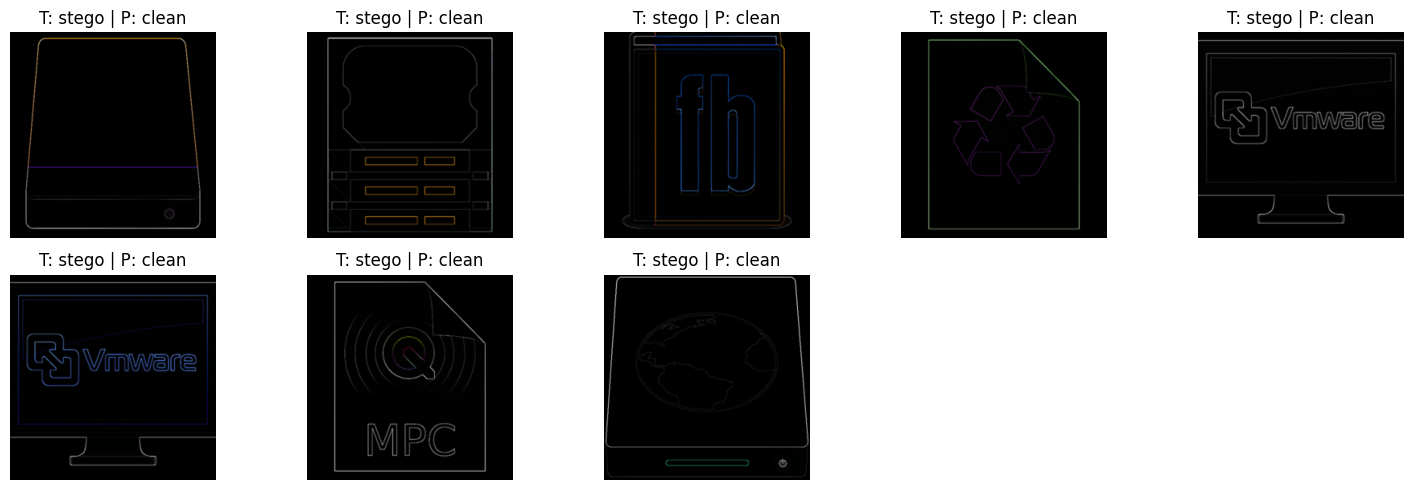


=== 📊 Rapport de classification ===

              precision    recall  f1-score   support

       clean       1.00      1.00      1.00      2000
       stego       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [11]:
model.load_state_dict(torch.load('best_model.pth'))

images, preds, labels = test_model(model, test_loader, device)

classes = ['clean', 'stego']
show_misclassified_images(images, preds, labels, classes, max_images=10)

generate_classification_report(labels, preds, classes)


le modèle a appris à reconnaitre facilement les images clean, par contre il a du mal à reconnaitres les images stégo:

modifications LSB subtiles ?
pas de diversité dans les stégo-images ?
en tout cas le modèle ne peut plus se reposer sur le fait qu'il y a beaucoup plus de stego que de clean.


à tester :
tester une résolution plus grande ???
augmentation, googd
fined tuning plus lent ?
features laplacian ou dct pour capter les changements fins

une loss pondéréee pour, pénaliser plus fort si mauvaise prédiction stégo ?

appliquer laplacian sur les images avant de les passer au CNN, utiliser à la fois l'image et son laplacien en input ?
